In [219]:
!pip install torchinfo

In [220]:
!wget https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv

--2024-05-10 12:13:38--  https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv [following]
--2024-05-10 12:13:39--  https://raw.githubusercontent.com/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284248 (278K) [text/plain]
Saving to: ‘GOOG.csv.7’

GOOG.csv.7          100%[===================>] 277.59K  --.-KB/s    in 0.03s   

2024-05-10 

In [221]:
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchinfo import summary
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import yfinance as yf
from itertools import product
import numpy as np

In [222]:
start = "2004-08-19"
interval = "1d"

# load s&p 500 data
gspc = yf.Ticker("^GSPC")
gspc_data = gspc.history(period="max", interval=interval, start=start)
gspc_data = gspc_data[["Open", "High", "Low", "Close", "Volume"]]

spy = yf.Ticker("SPY")
spy_data = spy.history(period="max", interval=interval, start=start)
spy_data = spy_data[["Open", "High", "Low", "Close", "Volume"]]
spy_data = spy_data.rename(columns={"Open": "spy_open", "High": "spy_high", "Low": "spy_low", "Close": "spy_close", "Volume": "spy_volume"})

goog = yf.Ticker("GOOG")
goog_data = goog.history(period="max", interval=interval, start=start)
goog_data = goog_data[["Open", "High", "Low", "Close", "Volume"]]
goog_data = goog_data.rename(columns={"Open": "goog_open", "High": "goog_high", "Low": "goog_low", "Close": "goog_close", "Volume": "goog_volume"})

aapl = yf.Ticker("AAPL")
aapl_data = aapl.history(period="max", interval=interval, start=start)
aapl_data = aapl_data[["Open", "High", "Low", "Close", "Volume"]]
aapl_data = aapl_data.rename(columns={"Open": "aapl_open", "High": "aapl_high", "Low": "aapl_low", "Close": "aapl_close", "Volume": "aapl_volume"})

amzn = yf.Ticker("AMZN")
amzn_data = amzn.history(period="max", interval=interval, start=start)
amzn_data = amzn_data[["Open", "High", "Low", "Close", "Volume"]]
amzn_data = amzn_data.rename(columns={"Open": "amzn_open", "High": "amzn_high", "Low": "amzn_low", "Close": "amzn_close", "Volume": "amzn_volume"})
amzn_data = amzn_data.dropna()

msft = yf.Ticker("MSFT")
msft_data = msft.history(period="max", interval=interval, start=start)
msft_data = msft_data[["Open", "High", "Low", "Close", "Volume"]]
msft_data = msft_data.rename(columns={"Open": "msft_open", "High": "msft_high", "Low": "msft_low", "Close": "msft_close", "Volume": "msft_volume"})
msft_data = msft_data.dropna()

# merge all stock data
df = pd.concat([gspc_data, spy_data, goog_data, aapl_data, amzn_data, msft_data], axis=1)
df = df.dropna()
df

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19 00:00:00-04:00,1095.170044,1095.170044,1086.280029,1091.229980,1249400000,75.200539,75.344351,74.769101,75.132057,39881600,...,2.013000,2.024000,1.817500,1.931500,253922000,17.074386,17.136816,16.862127,16.930799,46293000
2004-08-20 00:00:00-04:00,1091.229980,1100.260010,1089.569946,1098.349976,1199900000,75.063541,75.762059,74.995060,75.659340,44870900,...,1.923000,1.995500,1.905500,1.975500,135816000,16.937050,17.086881,16.880864,16.980751,46494800
2004-08-23 00:00:00-04:00,1098.349976,1101.400024,1094.729980,1095.680054,1021900000,75.707291,75.857947,75.364879,75.467598,33745100,...,1.994500,2.000000,1.955500,1.972500,110652000,17.074656,17.112224,16.980737,17.055872,39572200
2004-08-24 00:00:00-04:00,1095.680054,1100.939941,1092.819946,1096.189941,1092500000,75.768912,75.830549,75.227901,75.570312,30453100,...,1.986000,1.996500,1.916000,1.952500,152808000,17.156053,17.193621,16.961952,17.055872,40835300
2004-08-25 00:00:00-04:00,1096.189941,1106.290039,1093.239990,1104.959961,1192200000,75.556626,76.200357,75.262152,76.083939,38551400,...,1.953000,2.024500,1.908000,2.015000,145096000,17.037101,17.325123,17.018318,17.249987,53512700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03 00:00:00-04:00,5122.779785,5139.120117,5101.220215,5127.790039,3924990000,511.160004,512.549988,508.559998,511.290009,72756700,...,186.990005,187.869995,185.419998,186.210007,39172000,402.279999,407.149994,401.859985,406.660004,17446700
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,513.750000,516.609985,513.299988,516.570007,47264700,...,186.279999,188.750000,184.800003,188.699997,34725300,408.760010,413.929993,406.369995,413.540009,16996600
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,517.559998,518.570007,516.450012,517.140015,52561300,...,188.919998,189.940002,187.309998,188.759995,34048900,414.660004,414.670013,409.089996,409.339996,20018200


In [223]:
# df = pd.read_csv('GOOG.csv', index_col="Date")
# df = df.drop(['Adj Close'], axis = 1)

target_col = "Close"
features = list(df.columns.difference([target_col]))

forecast_lead = 1
target = f"{target_col}_lead{forecast_lead}"

df[target] = df[target_col].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]
df

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19 00:00:00-04:00,1095.170044,1095.170044,1086.280029,1091.229980,1249400000,75.200539,75.344351,74.769101,75.132057,39881600,...,2.024000,1.817500,1.931500,253922000,17.074386,17.136816,16.862127,16.930799,46293000,1098.349976
2004-08-20 00:00:00-04:00,1091.229980,1100.260010,1089.569946,1098.349976,1199900000,75.063541,75.762059,74.995060,75.659340,44870900,...,1.995500,1.905500,1.975500,135816000,16.937050,17.086881,16.880864,16.980751,46494800,1095.680054
2004-08-23 00:00:00-04:00,1098.349976,1101.400024,1094.729980,1095.680054,1021900000,75.707291,75.857947,75.364879,75.467598,33745100,...,2.000000,1.955500,1.972500,110652000,17.074656,17.112224,16.980737,17.055872,39572200,1096.189941
2004-08-24 00:00:00-04:00,1095.680054,1100.939941,1092.819946,1096.189941,1092500000,75.768912,75.830549,75.227901,75.570312,30453100,...,1.996500,1.916000,1.952500,152808000,17.156053,17.193621,16.961952,17.055872,40835300,1104.959961
2004-08-25 00:00:00-04:00,1096.189941,1106.290039,1093.239990,1104.959961,1192200000,75.556626,76.200357,75.262152,76.083939,38551400,...,2.024500,1.908000,2.015000,145096000,17.037101,17.325123,17.018318,17.249987,53512700,1105.089966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02 00:00:00-04:00,5049.319824,5073.209961,5011.049805,5064.200195,4381660000,504.149994,505.890015,499.549988,505.029999,62550200,...,185.100006,179.910004,184.720001,54303500,397.660004,399.929993,394.649994,397.839996,17709400,5127.790039
2024-05-03 00:00:00-04:00,5122.779785,5139.120117,5101.220215,5127.790039,3924990000,511.160004,512.549988,508.559998,511.290009,72756700,...,187.869995,185.419998,186.210007,39172000,402.279999,407.149994,401.859985,406.660004,17446700,5180.740234
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,513.750000,516.609985,513.299988,516.570007,47264700,...,188.750000,184.800003,188.699997,34725300,408.760010,413.929993,406.369995,413.540009,16996600,5187.700195


<Axes: xlabel='Date'>

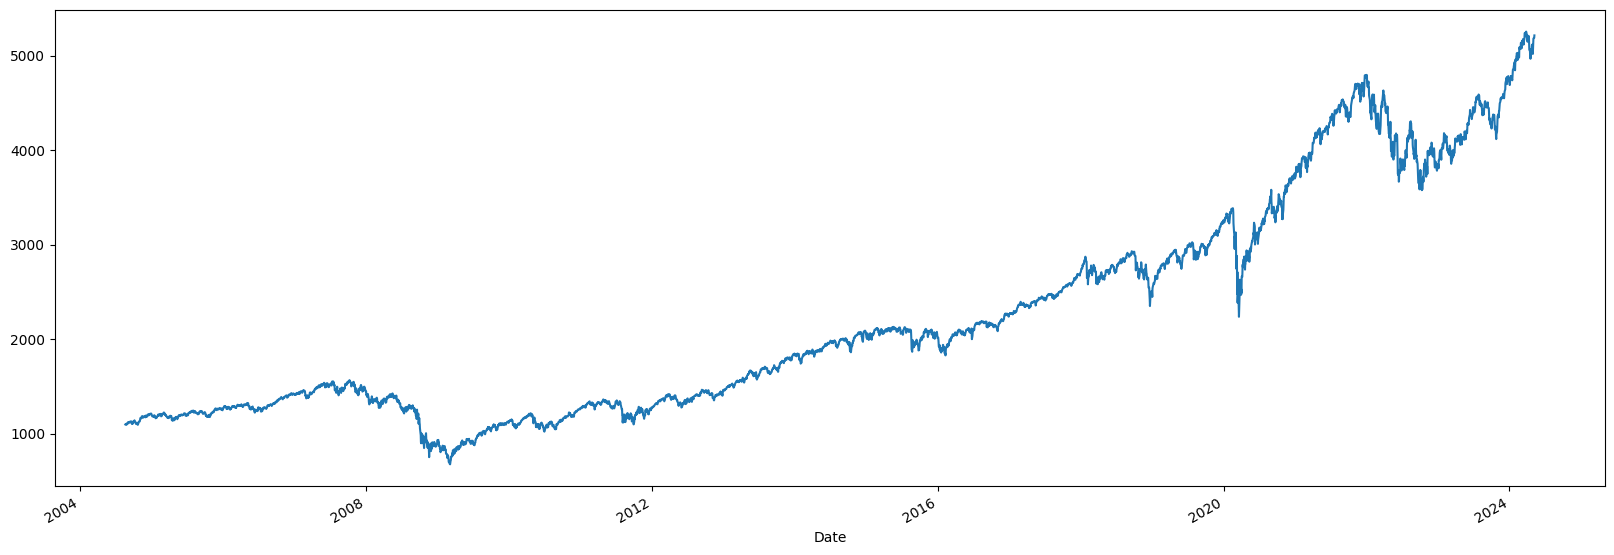

In [224]:
df[target].plot(figsize=(20, 7))

In [225]:
# add volatility as features
df["volatility"] = df["High"] - df["Low"]

# add ema as features
df["ema_5"] = df["Close"].ewm(span=5, adjust=False).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["ema_20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["ema_50"] = df["Close"].ewm(span=50, adjust=False).mean()
df["ema_100"] = df["Close"].ewm(span=100, adjust=False).mean()

<ipython-input-225-1103376d4c66>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-1103376d4c66>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-1103376d4c66>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-225-110

In [226]:
val_start = "2020-05-01"
test_start = "2022-05-01"


df_train = df.loc[:val_start].copy()
df_val = df.loc[val_start:test_start].copy()
df_test = df.loc[test_start:].copy()

In [227]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_val[c] = (df_val[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev
df_train.head()

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,msft_low,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19 00:00:00-04:00,-1.018745,-1.031223,-1.019979,-1.025609,-1.896172,-1.060412,-1.066181,-1.058256,-1.061513,-0.998557,...,-0.706717,-0.708534,-0.120300,-1.014656,-0.636731,-1.025344,-1.024854,-1.023720,-1.020204,-1.015375
2004-08-20 00:00:00-04:00,-1.025049,-1.023099,-1.014699,-1.014217,-1.934921,-1.062526,-1.059761,-1.054756,-1.053380,-0.947837,...,-0.706182,-0.707125,-0.113551,-1.018927,-0.527948,-1.021542,-1.022778,-1.022630,-1.019752,-1.015143
2004-08-23 00:00:00-04:00,-1.013657,-1.021279,-1.006418,-1.018489,-2.074264,-1.052595,-1.058287,-1.049028,-1.056337,-1.060939,...,-0.703332,-0.705005,-0.345067,-1.018111,-0.770892,-1.020434,-1.021858,-1.022052,-1.019487,-1.015003
2004-08-24 00:00:00-04:00,-1.017929,-1.022014,-1.009483,-1.017673,-2.018997,-1.051644,-1.058708,-1.051149,-1.054753,-1.094404,...,-0.703868,-0.705005,-0.302824,-1.004083,-0.683266,-1.019422,-1.020956,-1.021452,-1.019201,-1.014849
2004-08-25 00:00:00-04:00,-1.017113,-1.013475,-1.008809,-1.003641,-1.940949,-1.054919,-1.053024,-1.050619,-1.046830,-1.012079,...,-0.702260,-0.699527,0.121152,-1.003875,-0.385327,-1.014065,-1.017661,-1.019566,-1.018368,-1.014413


In [228]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [229]:
df.corr().style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,goog_open,goog_high,goog_low,goog_close,goog_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100
Open,1.000000,0.999925,0.999889,0.999806,0.137805,0.998917,0.998778,0.998909,0.998760,-0.408822,0.983790,0.983742,0.983832,0.983712,-0.493284,0.958317,0.958168,0.958463,0.958226,-0.611266,0.955792,0.955834,0.955819,0.955768,-0.328539,0.962107,0.961961,0.962134,0.961975,-0.506555,0.999557,0.515929,0.999876,0.999640,0.999106,0.997661,0.995473
High,0.999925,1.000000,0.999851,0.999895,0.141224,0.998974,0.998945,0.998977,0.998935,-0.405749,0.984039,0.984072,0.984098,0.984066,-0.492914,0.958938,0.958861,0.959101,0.958942,-0.610342,0.956094,0.956211,0.956134,0.956169,-0.327238,0.962585,0.962521,0.962631,0.962555,-0.504744,0.999636,0.521546,0.999891,0.999692,0.999242,0.997960,0.995920
Low,0.999889,0.999851,1.000000,0.999909,0.132473,0.998753,0.998614,0.998906,0.998747,-0.414786,0.983427,0.983387,0.983587,0.983479,-0.493924,0.957631,0.957489,0.957883,0.957656,-0.613151,0.955313,0.955363,0.955466,0.955421,-0.330858,0.961584,0.961442,0.961725,0.961574,-0.509695,0.999650,0.506723,0.999768,0.999432,0.998783,0.997170,0.994841
Close,0.999806,0.999895,0.999909,1.000000,0.136670,0.998794,0.998763,0.998935,0.998931,-0.410784,0.983671,0.983712,0.983834,0.983853,-0.493546,0.958234,0.958163,0.958487,0.958375,-0.611955,0.955648,0.955771,0.955799,0.955877,-0.329192,0.962050,0.961988,0.962193,0.962162,-0.507468,0.999713,0.513457,0.999797,0.999507,0.998950,0.997510,0.995337
Volume,0.137805,0.141224,0.132473,0.136670,1.000000,0.160583,0.163710,0.156515,0.159880,0.642936,0.197604,0.199358,0.195471,0.197274,-0.219397,0.208215,0.209564,0.206414,0.207835,0.003376,0.216603,0.218245,0.214516,0.216274,0.137995,0.196135,0.197988,0.193970,0.195797,0.177001,0.136733,0.504691,0.139426,0.142304,0.146760,0.155559,0.165227
spy_open,0.998917,0.998974,0.998753,0.998794,0.160583,1.000000,0.999943,0.999926,0.999872,-0.390321,0.986620,0.986639,0.986642,0.986581,-0.501859,0.965011,0.964868,0.965161,0.964934,-0.616459,0.957253,0.957350,0.957247,0.957262,-0.329860,0.967959,0.967851,0.967968,0.967848,-0.504340,0.998575,0.524600,0.998836,0.998643,0.998211,0.997050,0.995351
spy_high,0.998778,0.998945,0.998614,0.998763,0.163710,0.999943,1.000000,0.999879,0.999920,-0.387330,0.986698,0.986797,0.986737,0.986756,-0.501422,0.965442,0.965372,0.965607,0.965454,-0.615551,0.957411,0.957583,0.957418,0.957512,-0.328612,0.968253,0.968225,0.968277,0.968232,-0.502535,0.998545,0.529956,0.998782,0.998632,0.998283,0.997277,0.995716
spy_low,0.998909,0.998977,0.998906,0.998935,0.156515,0.999926,0.999879,1.000000,0.999930,-0.394552,0.986402,0.986433,0.986530,0.986479,-0.502414,0.964521,0.964389,0.964766,0.964549,-0.617820,0.956855,0.956965,0.956964,0.956984,-0.331707,0.967593,0.967492,0.967702,0.967588,-0.506753,0.998717,0.517150,0.998836,0.998564,0.998039,0.996736,0.994918
spy_close,0.998760,0.998935,0.998747,0.998931,0.159880,0.999872,0.999920,0.999930,1.000000,-0.391366,0.986501,0.986604,0.986631,0.986694,-0.502038,0.964938,0.964870,0.965185,0.965070,-0.616842,0.957070,0.957247,0.957177,0.957308,-0.330316,0.967888,0.967860,0.968000,0.967993,-0.504880,0.998691,0.522940,0.998781,0.998550,0.998106,0.996956,0.995278
spy_volume,-0.408822,-0.405749,-0.414786,-0.410784,0.642936,-0.390321,-0.387330,-0.394552,-0.391366,1.000000,-0.338336,-0.336986,-0.340477,-0.339032,0.169727,-0.307558,-0.306691,-0.308957,-0.308049,0.485839,-0.349844,-0.348702,-0.351698,-0.350463,0.353264,-0.314352,-0.313021,-0.316128,-0.314863,0.513759,-0.410685,0.237530,-0.406242,-0.401974,-0.395956,-0.385604,-0.375616


In [230]:
correlation = df.corr()[target]
correlation = correlation[abs(correlation) > 0.9]
correlation = correlation[correlation.index != target]
correlation

Open          0.999557
High          0.999636
Low           0.999650
Close         0.999713
spy_open      0.998575
spy_high      0.998545
spy_low       0.998717
spy_close     0.998691
goog_open     0.983450
goog_high     0.983489
goog_low      0.983613
goog_close    0.983615
aapl_open     0.958041
aapl_high     0.957966
aapl_low      0.958300
aapl_close    0.958165
amzn_open     0.955557
amzn_high     0.955692
amzn_low      0.955724
amzn_close    0.955791
msft_open     0.961963
msft_high     0.961902
msft_low      0.962110
msft_close    0.962059
ema_5         0.999544
ema_10        0.999262
ema_20        0.998717
ema_50        0.997302
ema_100       0.995145
Name: Close_lead1, dtype: float64

In [231]:

# features = correlation.index.tolist()
# features = ['Open','High','Low','Close']
features = ['Close']
features

['Close']

In [232]:
i = 4
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.0142],
        [-1.0185],
        [-1.0177],
        [-1.0036]])


In [233]:
# torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([1, 4, 1])
tensor([[[-1.0960],
         [-1.0682],
         [-1.0933],
         [-1.0926]]])


In [234]:
torch.manual_seed(101)
np.random.seed(101)
#################################
batch_size = 32
sequence_length = 90
#################################
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [235]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [236]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, filter, kernel_size=3, stride=1, padding=1):
        super(ResBlock, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels, filter, kernel_size, stride, padding)
        self.conv2 = torch.nn.Conv1d(filter, filter, kernel_size, stride, padding)
        self.linear = torch.nn.Linear(filter, out_channels)
        self.relu = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.bn2 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.dropout = nn.Dropout(0.2)
        # intialise weights of the attention mechanism
        self.weight = nn.Parameter(torch.zeros(1)).to(device)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.dropout(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.bn2(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.weight*out
        out += x.view(x.size(0), -1)
        return out

In [237]:
class ResNLS(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_layer, num_layer, num_feature=4, filter=64, kernel_size=3, dropout=0.2, bidirectional=False):
        super(ResNLS, self).__init__()
        self.resblock = torch.nn.ModuleList([ResBlock(in_channels, in_channels, filter) for i in range(num_feature)])
        self.bidirectional=bidirectional
        self.num_layers = num_layer
        self.hidden_layer = hidden_layer
        self.lstm = torch.nn.LSTM(num_feature, hidden_layer, num_layer, batch_first=True,dropout=dropout,bidirectional=bidirectional)
        self.linear = torch.nn.Linear(hidden_layer, out_channels)


    def forward(self, x):
        batch_size = x.size(0)
        out = torch.split(x, 1, 2)
        out_res = []

        for i in range(len(out)):
            out_res.append(self.resblock[i](out[i]))
        out = torch.stack(out_res, 2)

        h0 = torch.zeros(self.num_layers+self.num_layers*self.bidirectional, batch_size, self.hidden_layer).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers+self.num_layers*self.bidirectional, batch_size, self.hidden_layer).to(device).requires_grad_()
        _, (hn, _) = self.lstm(out, (h0, c0))
        out = self.linear(hn[-1]).flatten()
        return out

In [238]:
# Init from paper
num_consecutive_days = sequence_length
days_pred = 1
num_lstm_hiddensize = 512
lstm_layers = 1
num_features = len(features)
filters = 64
kernel_size = 3
dropout_lstm = 0.2
bidirectional = False



model = ResNLS(num_consecutive_days,
               days_pred,
               num_lstm_hiddensize,
               lstm_layers,
               num_features,
               filters,
               kernel_size,
               dropout_lstm,
               bidirectional)
model.to(device)
summary(model, input_size=(batch_size, num_consecutive_days, num_features))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Layer (type:depth-idx)                   Output Shape              Param #
ResNLS                                   [32]                      --
├─ModuleList: 1-1                        --                        --
│    └─ResBlock: 2-1                     [32, 90]                  --
│    │    └─Conv1d: 3-1                  [32, 64, 1]               17,344
│    │    └─ReLU: 3-2                    [32, 64, 1]               --
│    │    └─BatchNorm1d: 3-3             [32, 64, 1]               128
│    │    └─Dropout: 3-4                 [32, 64, 1]               --
│    │    └─Conv1d: 3-5                  [32, 64, 1]               12,352
│    │    └─ReLU: 3-6                    [32, 64, 1]               --
│    │    └─BatchNorm1d: 3-7             [32, 64, 1]               128
│    │    └─Linear: 3-8                  [32, 90]                  5,850
├─LSTM: 1-2                              [32, 90, 256]             265,216
├─Linear: 1-3                            [32, 1]                   

In [239]:
parameters_to_decay = []
for name, param in model.named_parameters():
    if 'conv1' in name or 'conv2' in name:
        parameters_to_decay.append(param)

weight_decay = 1e-5
learning_rate = 1e-3
optimizer = torch.optim.Adam([{'params': parameters_to_decay, 'weight_decay': weight_decay},
                              {'params': model.lstm.parameters()},
                              {'params': model.linear.parameters()}],
                             lr=learning_rate)
loss_function = nn.MSELoss()

In [240]:
param_grid = {
    'dropout_lstm': dropout_lstm,
    'weight_decay': weight_decay,
    'learning_rate': learning_rate,
    'num_lstm_hiddensize': num_lstm_hiddensize,
    'lstm_layers': lstm_layers,
    'filters': filters,
    'kernel_size': kernel_size,
    'bidirectional': bidirectional,
    'num_consecutive_days': num_consecutive_days,
    'days_pred': days_pred,
    'num_features': num_features,
    'batch_size': batch_size
}
for key, value in param_grid.items():
    print(f"{key}: {value}")

dropout_lstm: 0.2
weight_decay: 1e-05
learning_rate: 0.001
num_lstm_hiddensize: 256
lstm_layers: 1
filters: 64
kernel_size: 3
bidirectional: False
num_consecutive_days: 90
days_pred: 1
num_features: 1
batch_size: 32


In [241]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, best_val_loss):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), 'model.pth')
        print('Save new best model')
    return best_val_loss , avg_loss

In [242]:
best_val_loss = torch.inf
train_losses = []
val_losses = []
for ix_epoch in tqdm(range(100)):
    print(f"Epoch {ix_epoch}\n---------")
    train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    best_val_loss,avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
    val_losses.append(avg_loss)
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0
---------
Train loss: 0.07977073060652812
Test loss: 0.8038980463752523
Save new best model

Epoch 1
---------
Train loss: 0.004423391505336058
Test loss: 0.439679445407819
Save new best model

Epoch 2
---------
Train loss: 0.003432842003906356
Test loss: 0.2060600997065194
Save new best model

Epoch 3
---------
Train loss: 0.0031490696780946885
Test loss: 0.17242598498705775
Save new best model

Epoch 4
---------
Train loss: 0.0027532820893083547
Test loss: 0.20069779315963387

Epoch 5
---------
Train loss: 0.002828249987590337
Test loss: 0.08026778171188198
Save new best model

Epoch 6
---------
Train loss: 0.002782199161423881
Test loss: 0.04843484434240963
Save new best model

Epoch 7
---------
Train loss: 0.002339225468946801
Test loss: 0.05415663885651156

Epoch 8
---------
Train loss: 0.002441743962868537
Test loss: 0.07127978303469718

Epoch 9
---------
Train loss: 0.0022394508583426114
Test loss: 0.04337480993126519
Save new best model

Epoch 10
---------
Train loss: 0

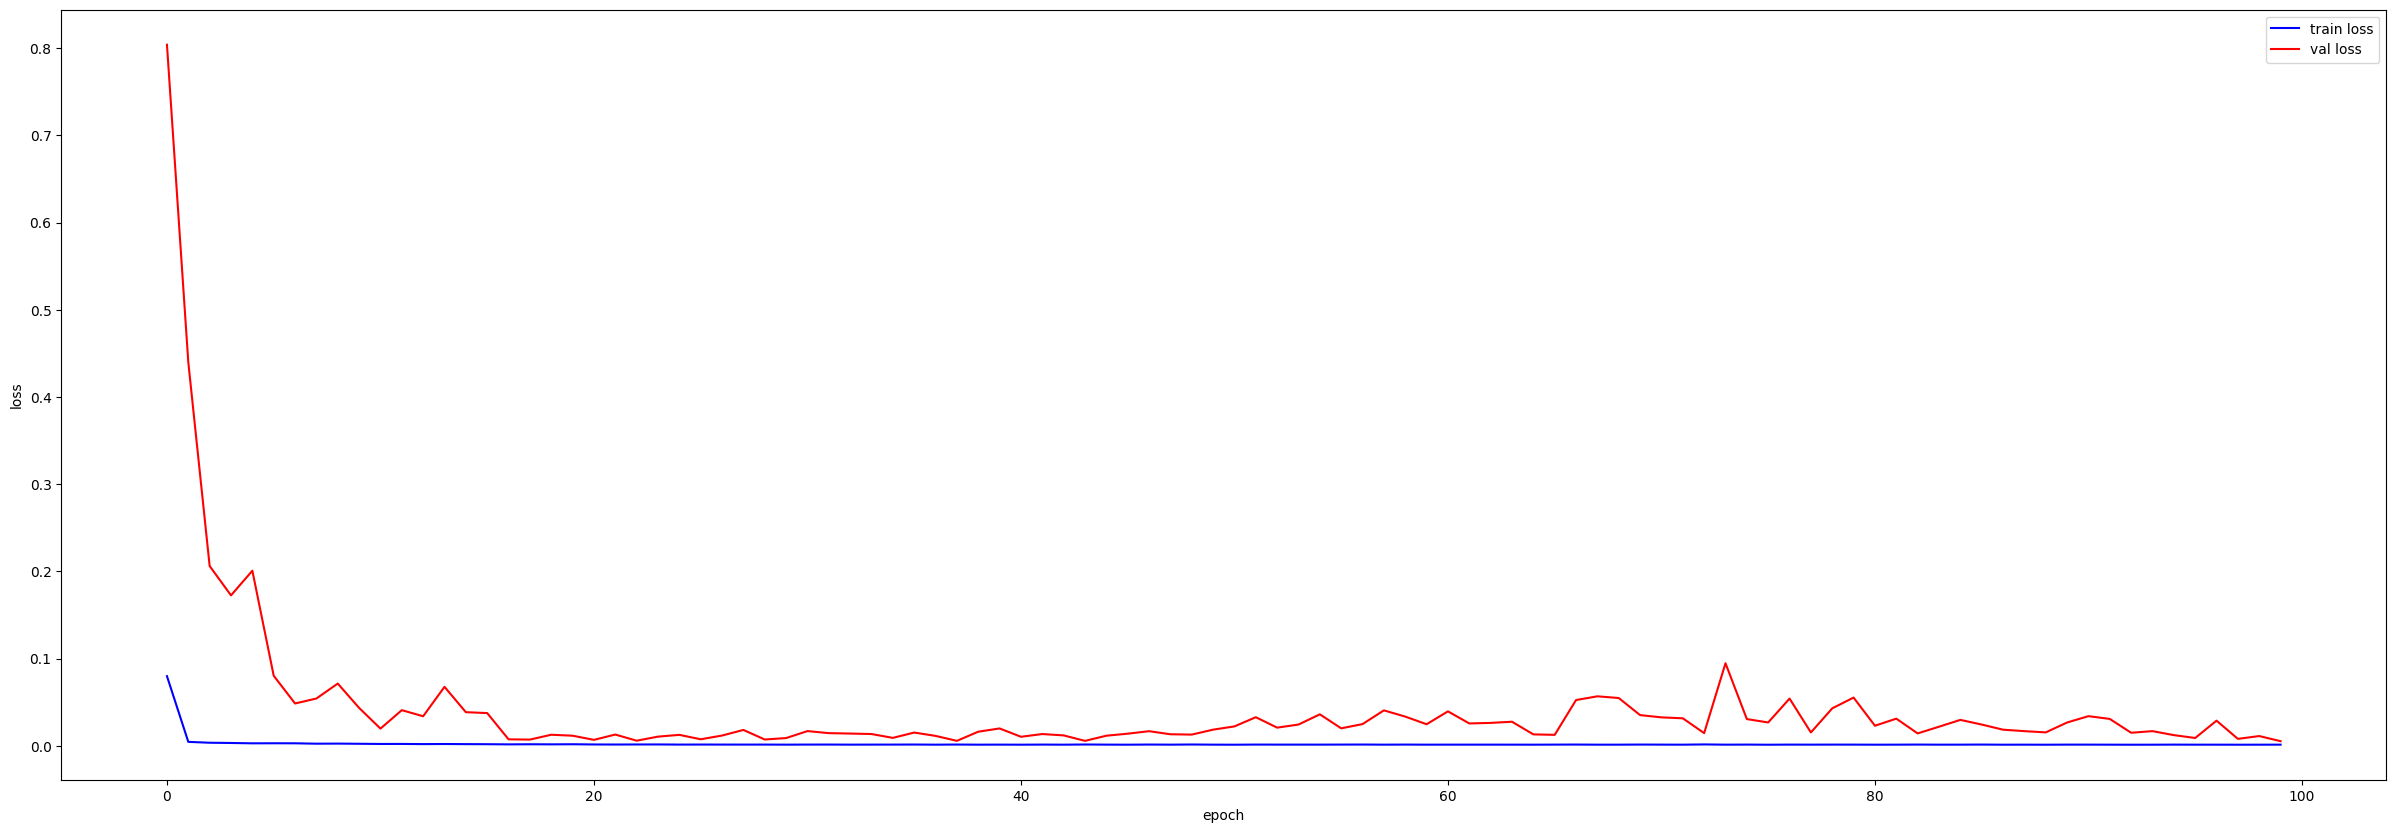

In [243]:
def plot_losses(train_loss,val_loss):
  plt.figure(figsize=(30, 10))
  plt.plot(train_loss,color="blue",label="train loss")
  plt.plot(val_loss,color="red",label="val loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

plot_losses(train_losses,val_losses)

In [244]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star.detach().cpu()), 0)
    return output

In [245]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"

df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = None
df_test_out = pd.DataFrame()
df_test_out[target] = df_test[target]
df_test_out[ystar_col] = df_test[ystar_col]

df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

for c in df_test_out.columns:
    df_test_out[c] = df_test_out[c] * target_stdev + target_mean

print(df_test_out[[target, ystar_col]])

                           Close_lead1  Model forecast
Date                                                  
2022-05-02 00:00:00-04:00  4175.479980     4165.011719
2022-05-03 00:00:00-04:00  4300.169922     4180.887695
2022-05-04 00:00:00-04:00  4146.870117     4285.627930
2022-05-05 00:00:00-04:00  4123.339844     4205.862305
2022-05-06 00:00:00-04:00  3991.239990     4141.512695
...                                ...             ...
2024-05-02 00:00:00-04:00  5127.790039     5033.217285
2024-05-03 00:00:00-04:00  5180.740234     5097.610352
2024-05-06 00:00:00-04:00  5187.700195     5157.443848
2024-05-07 00:00:00-04:00  5187.669922     5174.194824
2024-05-08 00:00:00-04:00  5214.080078     5172.444336

[508 rows x 2 columns]


In [246]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
def MASE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y) / torch.mean(torch.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def sharp_ratio(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean((pred - y) / torch.std(y)))
# print validation loss

print( 'best_val_loss =', best_val_loss )
print( 'MSE =', mean_squared_error(df_test[target], df_test['Model forecast']))
print( 'MASE =', MASE(df_test_out[target], df_test_out['Model forecast']))
print( 'RMSE =', math.sqrt(mean_squared_error(df_test_out[target], df_test_out['Model forecast'])) )
print( 'SMAPE =', SMAPE(df_test_out[target], df_test_out['Model forecast']))
print( 'MAE =', MAE(df_test_out[target], df_test_out['Model forecast']))
print( 'sharp_ratio =', sharp_ratio(df_test_out[target], df_test_out['Model forecast']))

best_val_loss = 0.0052103795314906165
MSE = 0.006517667007648891
MASE = 1.2435592873857795
RMSE = 50.47047948525892
SMAPE = 0.9355542983305489
MAE = 39.12857656403789
sharp_ratio = -0.006600577172174453


In [247]:
fig = px.line(df_out, labels={'value': target, 'created_at': 'Date'})
fig.add_vline(x=val_start, line_width=4, line_dash="dash")
fig.add_vline(x=test_start, line_width=4, line_dash="dash")

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [248]:
fig = px.line(df_test_out[[target, ystar_col]], labels={'value': target, 'created_at': 'Date'})
# fig.add_vline(x=val_start, line_width=4, line_dash="dash")
# fig.add_vline(x=test_start, line_width=4, line_dash="dash")

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [185]:
# param_grid = {
#     'dropout_lstm': [0.2],
#     'weight_decay': [1e-4, 1e-5],
#     'learning_rate': [1e-3, 5e-4],
#     'num_lstm_hiddensize': [64],
#     'lstm_layers': [1],
#     'filters': [64],
#     'kernel_size': [3],
#     'bidirectional': [False],
#     'num_consecutive_days': [60],
#     'days_pred': [1],
#     'num_features': [len(features)],
#     'batch_size': [32]
# }

# param_combinations = list(product(*param_grid.values()))
# len(param_combinations)

In [186]:

def grid_search(param_combinations):
    best_val_loss_sin = torch.inf
    best_val_loss_list = []
    best_train_loss_list = []
    best_params = None
    best_val_loss = torch.inf
    best_model = None
    best_train_dataloader = None
    best_val_dataloader = None
    best_test_dataloader = None

    for params in tqdm(param_combinations):
        print(params)
        dropout_lstm, weight_decay, learning_rate, num_lstm_hiddensize, lstm_layers, filters, kernel_size, bidirectional, num_consecutive_days, days_pred, num_features, batch_size = params
        model = ResNLS(num_consecutive_days,
                       days_pred,
                       num_lstm_hiddensize,
                       lstm_layers,
                       num_features,
                       filters,
                       kernel_size,
                       dropout_lstm,
                       bidirectional)
        model.to(device)

        train_dataset = SequenceDataset(
            df_train,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        val_dataset = SequenceDataset(
            df_val,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        test_dataset = SequenceDataset(
            df_test,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        parameters_to_decay = []
        for name, param in model.named_parameters():
            if 'conv1' in name or 'conv2' in name:
                parameters_to_decay.append(param)

        optimizer = torch.optim.Adam([
            {'params': parameters_to_decay, 'weight_decay': weight_decay},
            {'params': model.lstm.parameters()},
            {'params': model.linear.parameters()}
        ], lr=learning_rate)

        loss_function = nn.MSELoss()

        train_losses = []
        val_losses = []
        for ix_epoch in range(150):
            print(f"Epoch {ix_epoch}\n---------")
            train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
            best_val_loss, avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
            val_losses.append(avg_loss)
            print()

        if best_val_loss < best_val_loss_sin:
            best_params = params
            best_val_loss_list = val_losses
            best_train_loss_list = train_losses
            best_val_loss_sin = best_val_loss
            best_train_dataloader = train_loader
            best_val_dataloader = val_loader
            best_test_dataloader = test_loader
            best_model = model

    print(f"Best params: {best_params}")
    print(f"Best val loss: {best_val_loss_sin}")
    plot_losses(best_train_loss_list, best_val_loss_list)

    ystar_col = "Model forecast"

    df_train[ystar_col] = predict(best_train_dataloader, best_model).numpy()
    df_val[ystar_col] = predict(best_val_dataloader, best_model).numpy()
    df_test[ystar_col] = predict(best_test_dataloader, best_model).numpy()

    df_out = None
    df_test_out = pd.DataFrame()
    df_test_out[target] = df_test[target]
    df_test_out[ystar_col] = df_test[ystar_col]

    df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * target_stdev + target_mean

    for c in df_test_out.columns:
        df_test_out[c] = df_test_out[c] * target_stdev + target_mean

    print(df_test_out[[target, ystar_col]])

    print( 'best_val_loss =', best_val_loss )
    print( 'MSE =', mean_squared_error(df_test[target], df_test['Model forecast']))
    print( 'MASE =', MASE(df_test_out[target], df_test_out['Model forecast']))
    print( 'RMSE =', math.sqrt(mean_squared_error(df_test_out[target], df_test_out['Model forecast'])) )
    print( 'SMAPE =', SMAPE(df_test_out[target], df_test_out['Model forecast']))
    print( 'MAE =', MAE(df_test_out[target], df_test_out['Model forecast']))
    print( 'sharp_ratio =', sharp_ratio(df_test_out[target], df_test_out['Model forecast']))

    plt.figure(figsize=(20, 7))
    plt.plot(df_test_out[target], label='True')
    plt.plot(df_test_out[ystar_col], label='Forecast')
    plt.legend()

    return best_params

def copy_from_best(best_params):
    dropout_lstm, weight_decay, learning_rate, num_lstm_hiddensize, lstm_layers, filters, kernel_size, bidirectional, num_consecutive_days, days_pred, num_features, batch_size = best_params
    param_grid = {
      'dropout_lstm': [dropout_lstm],
      'weight_decay': [weight_decay],
      'learning_rate': [learning_rate],
      'num_lstm_hiddensize': [num_lstm_hiddensize],
      'lstm_layers': [lstm_layers],
      'filters': [filters],
      'kernel_size': [kernel_size],
      'bidirectional': [bidirectional],
      'num_consecutive_days': [num_consecutive_days],
      'days_pred': [days_pred],
      'num_features': [num_features],
      'batch_size': [batch_size]
    }
    return param_grid


In [187]:
param_grid = {
    'dropout_lstm': [dropout_lstm],
    'weight_decay': [weight_decay],
    'learning_rate': [learning_rate],
    'num_lstm_hiddensize': [num_lstm_hiddensize],
    'lstm_layers': [lstm_layers],
    'filters': [filters],
    'kernel_size': [kernel_size],
    'bidirectional': [bidirectional],
    'num_consecutive_days': [num_consecutive_days],
    'days_pred': [days_pred],
    'num_features': [num_features],
    'batch_size': [batch_size]
}
# param_combinations = list(product(*param_grid.values()))[0]

In [94]:
param_grid = copy_from_best(list(product(*param_grid.values()))[0])
param_grid['weight_decay'] = [1e-4, 1e-5]
param_grid['learning_rate'] = [1e-3,5e-4]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)
param_grid = copy_from_best(best_params)
for key, value in param_grid.items():
    print(f"{key}: {value}")

  0%|          | 0/4 [00:00<?, ?it/s]

(0.2, 0.0001, 0.001, 64, 1, 64, 3, False, 60, 1, 1, 32)
Epoch 0
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.1731083038302454
Test loss: 1.6247229111613706
Save new best model

Epoch 1
---------
Train loss: 0.004298256573102046
Test loss: 1.0601578960195184
Save new best model

Epoch 2
---------
Train loss: 0.0034975688406942234
Test loss: 0.6334810825646855
Save new best model

Epoch 3
---------
Train loss: 0.0029833240940558515
Test loss: 0.4096843290608376
Save new best model

Epoch 4
---------
Train loss: 0.002635518108182887
Test loss: 0.26077657217683736
Save new best model

Epoch 5
---------
Train loss: 0.002632296764791282
Test loss: 0.23022538790246472
Save new best model

Epoch 6
---------
Train loss: 0.002825265339080004
Test loss: 0.2222159070079215
Save new best model

Epoch 7
---------
Train loss: 0.002599238257032759
Test loss: 0.20715706516057253
Save new best model

Epoch 8
---------
Train loss: 0.0022376733099771363
Test loss: 0.15812012366950512
Save new best model

Epoch 9
---------
Train loss: 0.0022343565698622935
Test loss: 0.15309745556442067
Save new bes

KeyboardInterrupt: 

In [ ]:
param_grid = copy_from_best(best_params)
param_grid['bidirectional'] = [False]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

param_grid = copy_from_best(best_params)
for key, value in param_grid.items():
    print(f"{key}: {value[0]}")

In [ ]:
param_grid = copy_from_best(best_params)
param_grid['num_consecutive_days'] = [30, 60, 90, 120]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

param_grid = copy_from_best(best_params)
for key, value in param_grid.items():
    print(f"{key}: {value[0]}")

  0%|          | 0/4 [00:00<?, ?it/s]

(0.2, 1e-05, 0.001, 64, 1, 64, 3, False, 90, 1, 1, 32)
Epoch 0
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.16396687308236235
Test loss: 1.5747916171094403
Save new best model

Epoch 1
---------
Train loss: 0.004312871356359532
Test loss: 1.0005638361908495
Save new best model

Epoch 2
---------
Train loss: 0.003742994045868756
Test loss: 0.6790850351098925
Save new best model

Epoch 3
---------
Train loss: 0.0031008300640913205
Test loss: 0.4729982839198783
Save new best model

Epoch 4
---------
Train loss: 0.0028939232077156646
Test loss: 0.4107893002219498
Save new best model

Epoch 5
---------
Train loss: 0.0028377237664948727
Test loss: 0.2922214066493325
Save new best model

Epoch 6
---------
Train loss: 0.0026134442399075677
Test loss: 0.2650718225049786
Save new best model

Epoch 7
---------
Train loss: 0.0023226714782199013
Test loss: 0.1888204971619416
Save new best model

Epoch 8
---------
Train loss: 0.0023788963852923424
Test loss: 0.2077919787261635

Epoch 9
---------
Train loss: 0.0022130522467646626
Test loss: 0.14465234527597204
Save new best model

Epoch 10
--

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.14172541201602848
Test loss: 1.1260406663641334

Epoch 1
---------
Train loss: 0.0038750212641447904
Test loss: 0.661870650772471

Epoch 2
---------
Train loss: 0.003547823920774634
Test loss: 0.43697026040172204

Epoch 3
---------
Train loss: 0.0032116168445246594
Test loss: 0.2340796716598561

Epoch 4
---------
Train loss: 0.002814066073399097
Test loss: 0.25248742138501257

Epoch 5
---------
Train loss: 0.002791512179218473
Test loss: 0.15929233306087554

Epoch 6
---------
Train loss: 0.002623036744133119
Test loss: 0.18043516797479242

Epoch 7
---------
Train loss: 0.0024178749492068984
Test loss: 0.08563409265480004

Epoch 8
---------
Train loss: 0.0023611515897491407
Test loss: 0.11572529797558673

Epoch 9
---------
Train loss: 0.0021855549942213864
Test loss: 0.07821269641863182

Epoch 10
---------
Train loss: 0.002331743653837381
Test loss: 0.11362971848575398

Epoch 11
---------
Train loss: 0.002080776918333985
Test loss: 0.037649566074833274

Epoch 12
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.08371626505170078
Test loss: 0.6399741705972701

Epoch 1
---------
Train loss: 0.0035300645897457855
Test loss: 0.235271567304153

Epoch 2
---------
Train loss: 0.00318879552885905
Test loss: 0.10672104096738622

Epoch 3
---------
Train loss: 0.003083961083546221
Test loss: 0.15637250908184797

Epoch 4
---------
Train loss: 0.002975456318968246
Test loss: 0.03567512266454287

Epoch 5
---------
Train loss: 0.0027119981720217412
Test loss: 0.08863268070854247

Epoch 6
---------
Train loss: 0.002908724101988839
Test loss: 0.03941794886486605

Epoch 7
---------
Train loss: 0.002391365856672036
Test loss: 0.043660296098096296

Epoch 8
---------
Train loss: 0.002272813346221923
Test loss: 0.06437795329838991

Epoch 9
---------
Train loss: 0.002410070061863911
Test loss: 0.06295334314927459

Epoch 10
---------
Train loss: 0.002229449947574927
Test loss: 0.032095143615151756

Epoch 11
---------
Train loss: 0.0020054444340207884
Test loss: 0.009401675051776692

Epoch 12
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.13455069513574633
Test loss: 0.7364628672366962

Epoch 1
---------
Train loss: 0.003379128510958605
Test loss: 0.34429540671408176

Epoch 2
---------
Train loss: 0.003107880605966784
Test loss: 0.11598219907318708

Epoch 3
---------
Train loss: 0.0026300349230540076
Test loss: 0.19404630630742759

Epoch 4
---------
Train loss: 0.0031441888582306884
Test loss: 0.17185570090077817

Epoch 5
---------
Train loss: 0.002520822973888097
Test loss: 0.1061586607247591

Epoch 6
---------
Train loss: 0.0024652269799374945
Test loss: 0.08674982539378107

Epoch 7
---------
Train loss: 0.002287367507139401
Test loss: 0.037317509995773435

Epoch 8
---------
Train loss: 0.0021690207274420365
Test loss: 0.015832520701223984

Epoch 9
---------
Train loss: 0.002243427618879885
Test loss: 0.07601374574005604

Epoch 10
---------
Train loss: 0.0020774854436298954
Test loss: 0.016487003333168104

Epoch 11
---------
Train loss: 0.0020171063867652967
Test loss: 0.022596770140808076

Epoch 12
----

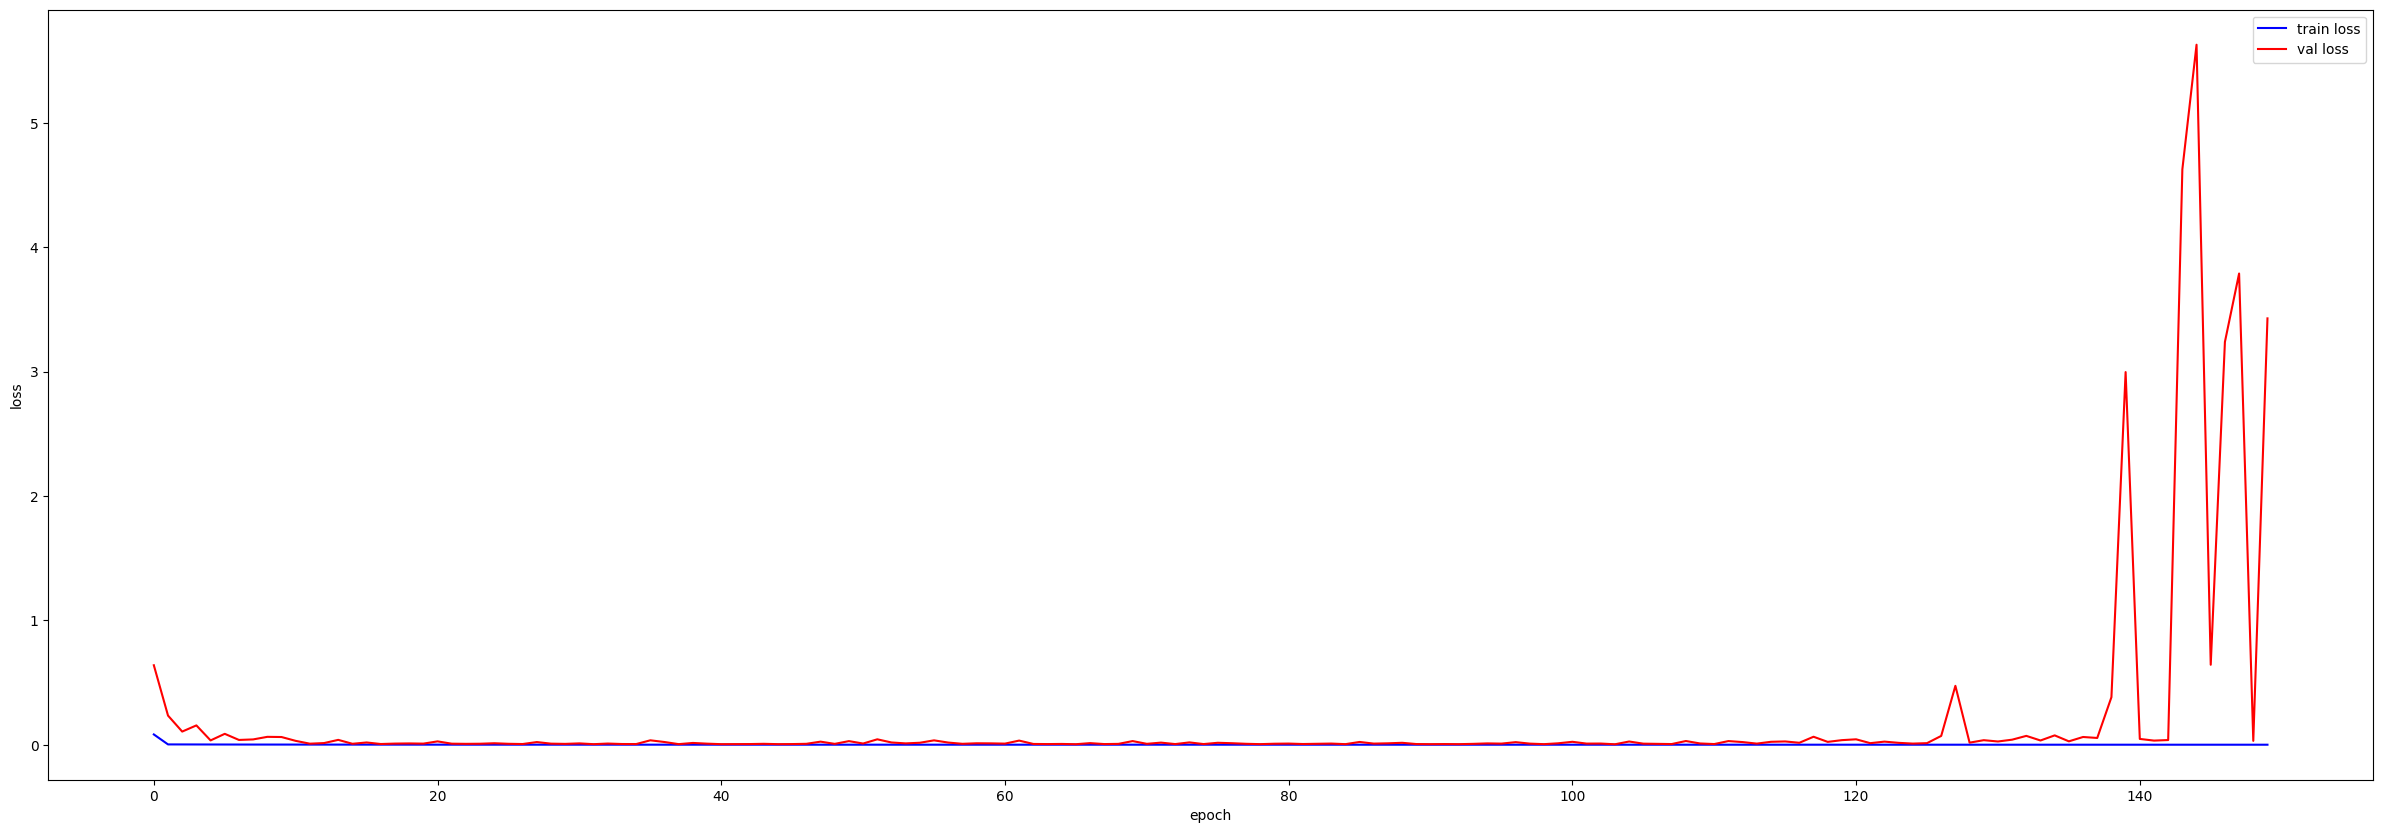

                           Close_lead1  Model forecast
Date                                                  
2022-05-02 00:00:00-04:00  4175.479980     2586.339111
2022-05-03 00:00:00-04:00  4300.169922     2619.761230
2022-05-04 00:00:00-04:00  4146.870117     2806.587891
2022-05-05 00:00:00-04:00  4123.339844     2419.795898
2022-05-06 00:00:00-04:00  3991.239990     2675.910156
...                                ...             ...
2024-05-02 00:00:00-04:00  5127.790039     2443.333740
2024-05-03 00:00:00-04:00  5180.740234     2398.638672
2024-05-06 00:00:00-04:00  5187.700195     2335.179443
2024-05-07 00:00:00-04:00  5187.669922     2275.480957
2024-05-08 00:00:00-04:00  5214.080078     2408.344238

[508 rows x 2 columns]
best_val_loss = 0.004629178089089692
MSE = 5.858392271945482
MASE = 4.595687662583593
RMSE = 1513.1448576231696
SMAPE = 34.822764289598865
MAE = 1267.5792387714537
sharp_ratio = 2.351815905108884
dropout_lstm: 0.2
weight_decay: 1e-05
learning_rate: 0.001
num_ls

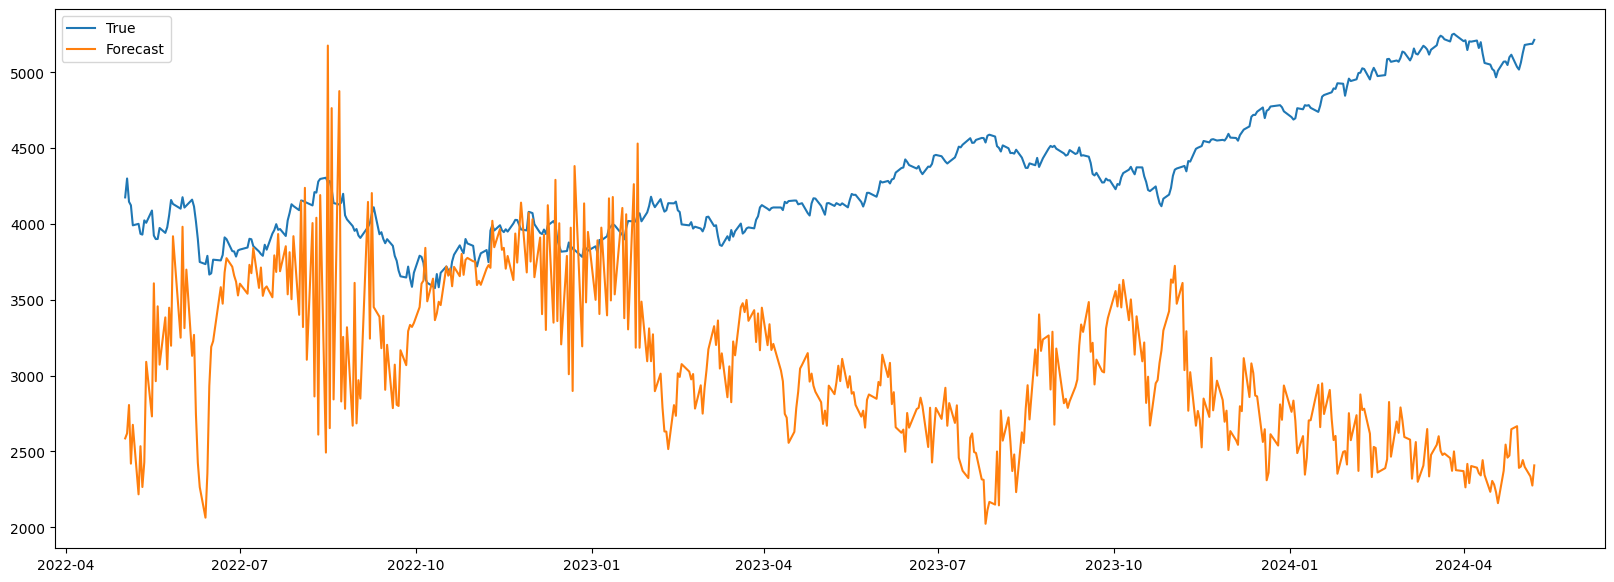

In [188]:
param_grid = copy_from_best(best_params)
param_grid['num_lstm_hiddensize'] = [64, 128, 256, 512]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

param_grid = copy_from_best(best_params)
for key, value in param_grid.items():
    print(f"{key}: {value[0]}")

In [ ]:
param_grid = copy_from_best(best_params)
param_grid['lstm_layers'] = [1, 3, 5]
param_grid['dropout_lstm'] = [0.0, 0.2]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

param_grid = copy_from_best(best_params)
for key, value in param_grid.items():
    print(f"{key}: {value[0]}")